## Setup

In [1]:
import glob
import os
import subprocess
import pickle as cPickle
import ast
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import numpy as np
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pandas as pd
import seaborn as sns


# Setup #

In [2]:
#path depending on timebin
pca_res_path="./c-transfer"
pcmci_res_path="./output"
f1_scores_path="./output_f1-scores_lag1/mapSearchIndices3_tauDiff0" #path to subnetwork F1-scores
model_names=['ACCESS-CM2', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC-ES2L',
             'MPI-ESM1-2-HR', 'UKESM1-0-LL']


In [3]:
related_models=[] #wie am besten machen, falls überhaupt so? Hier mal als Äquivalenzklassen
related_models.append((0, 6, 10))
related_models.append((1,))
related_models.append((2,))
related_models.append((3,))
related_models.append((4,))
related_models.append((5,))
related_models.append((0, 6, 10))
related_models.append((7,))
related_models.append((8,))
related_models.append((9,))
related_models.append((0, 6, 10))

In [4]:
f1Scores={}
f1ScoresLinks={}
links={}
for file in os.listdir(f1_scores_path):
    f1_scores_single_path=os.path.join(f1_scores_path, file)
    f1_scores_single=pickle.load(open(f1_scores_single_path,"rb"))
    pc_alpha=f1_scores_single['pc_alpha']
    n_kept_comp=f1_scores_single['n_kept_comp']
    if 'selected_comps' in f1_scores_single.keys():
        selected_comps=f1_scores_single['selected_comps']
    else:
        selected_comps=f1_scores_single['selected_komps']        
    treshold=f1_scores_single['treshold']
    links[treshold]=f1_scores_single['links']
    f1Scores[(pc_alpha, n_kept_comp, str(selected_comps), treshold)]=f1_scores_single['f1Scores']  
    f1ScoresLinks[(pc_alpha, n_kept_comp, str(selected_comps), treshold)]=(f1_scores_single['f1Scores'], f1_scores_single['links'])

In [5]:
f1Scores_={} #f1Scores sortiert bzw. die einträge der keys sortiert nach alpha_value
for key in f1Scores:
    scores=f1Scores[key]
    tempList={}
    for element in scores:
        for key2 in element:
            tempList[key2]=element[key2]
    sorted_dict = dict(sorted(tempList.items()))
    f1Scores_[key]=sorted_dict
    

## Methods

In [6]:
avg_f1_scores_models={} #avg F1-Score for each refModel F1-Matrix
for key in f1Scores_:
    scores=f1Scores_[key]
    avg_f1_scores_models.setdefault(key, {})
    for key2 in scores:
        avg_f1_scores_models[key][key2]=np.nanmean(scores[key2], axis=(2, 3)) #also avg f1 score für key1=pc_alpha und key2=refDataSet, avg F1-Score pro Model

In [7]:
#metric1 for all refDatasets. Returns average f1-score-metric1-distance for all refDatasets
def metric1(f1scores): #f14d matrix
    result=[]
    for i,refDataset in enumerate(f1scores):
        scores=f1scores[i]
        min_scores=[]
        max_scores=[]
        for element in scores:
            arr=np.array(element)
            min_scores.append(np.nanmin(arr))
            max_scores.append(np.nanmax(arr))
        result.append(np.mean(np.subtract(max_scores, min_scores)))
    return result

In [8]:
def metric2_(key, f1scores, relModelsTuple, refModelIndex, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
    for i, modelIndex in enumerate(relModelsTuple):
        for j, model in enumerate(model_names):
            if j not in relModelsTuple:
                val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                avgF1Distance[i][j]=val
                                        
    return avgF1Distance, np.nanmean(avgF1Distance)
        
    
    

In [9]:
def metric2(key, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1DistanceFinal=[]
    for refModelIndex, model in enumerate(model_names):
        relModelsTuple=related_models[refModelIndex]
        avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
        for i, modelIndex in enumerate(relModelsTuple):
            for j, model in enumerate(model_names):
                if j not in relModelsTuple:
                    val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                    avgF1Distance[i][j]=val
        avgF1DistanceFinal.append(np.nanmean(avgF1Distance))
    #print(key, np.nanmean(np.array(avgF1DistanceFinal)))
    return None, np.nanmean(np.array(avgF1DistanceFinal))
        
    
    

In [10]:
def plot_metric2_div_metric1(key):
    # Gleichmäßig verteilte x-Werte erstellen
    values=metric2_div_metric1[key]
    x_values, y_values = zip(*values)
    x_values=list(x_values)
    y_values=list(y_values)
    x_uniform = np.linspace(min(x_values), max(x_values), len(x_values))
    labels=x_values

    # Plot erstellen
    plt.plot(x_uniform, y_values, marker='o', linestyle='-')

    # Labels hinzufügen
    for i, txt in enumerate(labels):
        plt.annotate(txt, (x_uniform[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
        
    plotTitle='Nr. of components: ' + str(key[1]) + ', pc_alpha: ' + str(key[0]) + ', hash of selected_comps: ' + str(hash(str(key[2])))
    plt.title(plotTitle)
    plt.ylabel('F1-Score')
    plt.figtext(0, 0, 'The resulting F1-Scores for N components, specific pc_alpha (see title) and different alpha_values vizualized')

    plt.ylim(0, 2)
    
    # Plot anzeigen
    plt.show()

In [11]:
metric1Mins={} #Mins for the metric1 mean values per (alphaValue, n_kept_comp)
for key in f1Scores_:
    metric1values=[]
    f1_score_single=f1Scores_[key]
    for key2 in f1_score_single:
        metric1values.append(   (key2, np.mean((metric1(f1_score_single[key2]))))   )
    metric1Mins[key]=min(metric1values, key = lambda t: t[1])

        


In [12]:
metric2Maxs={}
for key in f1Scores_:
    metric2values=[]
    f1_score_single=f1Scores_[key]
    for key2 in f1_score_single:
        #metric2values.append((key2, metric2_(key, None, related_models[0], 6, key2)[1]))
        metric2values.append((key2, metric2(key, key2)[1]))

    metric2Maxs[key]=max(metric2values, key = lambda t: t[1])

In [13]:
metric2_div_metric1_maxs={}
metric2_div_metric1={}
for key in f1Scores_:
    metric2divmetric1values=[]
    f1_score_single=f1Scores_[key]
    metric2_div_metric1.setdefault(key, [])
    for key2 in f1_score_single:
        m1=np.mean(metric1(f1_score_single[key2]))
        #m2=metric2_(key, None, related_models[0], 6, key2)[1]
        m2=metric2(key, key2)[1]
        metric2divmetric1values.append((key2, m2/m1, m2, m1))
        metric2_div_metric1[key].append((key2, m2/m1))
    metric2_div_metric1_maxs[key]=max(metric2divmetric1values, key = lambda t: t[1])

In [14]:
metric2_div_metric1_maxs_2={} #(comps, pc_alpha, alpha_value): F1-Score  wobei alpha_value für den max erreichten F1-Score gegeben ist
for key in metric2_div_metric1_maxs:
    pc_alpha=key[0]
    comps=key[1]
    sel_comps=key[2]
    alpha_value=metric2_div_metric1_maxs[key][0]
    metric2_div_metric1_maxs_2[(comps,pc_alpha,alpha_value,sel_comps)]=metric2_div_metric1_maxs[key][1]

In [15]:
sorted_dict_komps = dict(sorted(metric2_div_metric1_maxs.items(), key=lambda x: x[0][0])) #sortiert nach comps, dann pc_alpha

In [16]:
sorted_dict_m2divm1 = dict(sorted(sorted_dict_komps.items(), key=lambda item: item[1][1], reverse=True))

In [17]:
#dict(sorted(sorted_dict_m2divm1.items(), key=lambda item: item[1][1], reverse=True))

In [18]:
#for key in f1ScoresLinks[ (0.025, 100, 'range(0, 100)', (0, 9))][1]:
 #   print(key,f1ScoresLinks[ (0.025, 100, 'range(0, 100)', (0, 9))][1][key])

# Visualization

In [19]:
toPlot=[]
for key in metric2_div_metric1_maxs:
    under,upper=key[3]
    metricScore=metric2_div_metric1_maxs[key][1]
    #if(under,upper) != (0,0):
    toPlot.append((under, upper, metricScore))

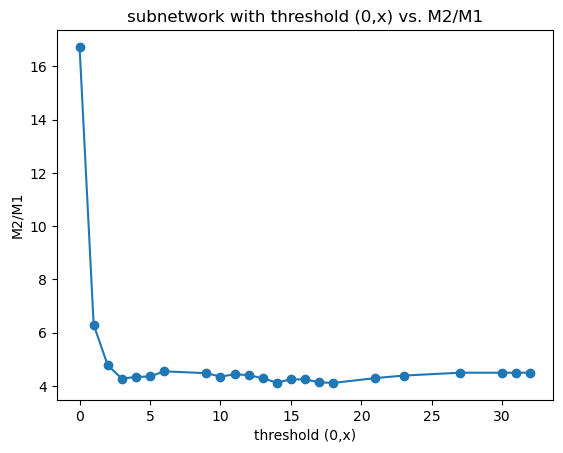

In [20]:
filtered_data0 = [(tup[1], tup[2]) for tup in toPlot if tup[0] == 0]
filtered_data0 = sorted(filtered_data0, key=lambda x: x[0])
filtered_data0.pop()
x_values, y_values = zip(*filtered_data0)

# Plot erstellen
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('threshold (0,x)')
plt.ylabel('M2/M1')
plt.title('subnetwork with threshold (0,x) vs. M2/M1')
#plt.savefig('./BilderBA/subnetwork_threshold_(0.x)_f1scorePENALTY=50.pdf', format='pdf')

plt.show()                    #warum mit absoluten threshold und nicht relativen?also in %

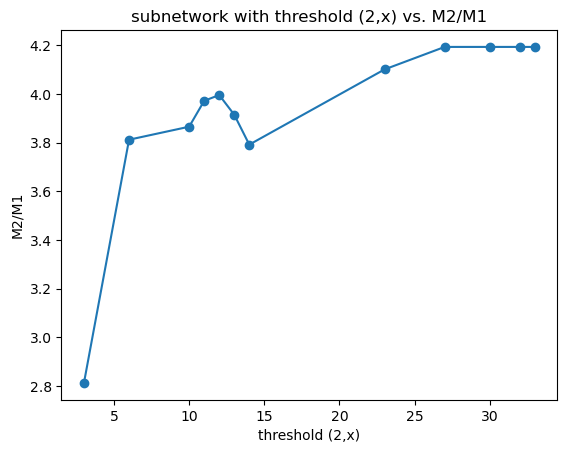

In [21]:
filtered_data2 = [(tup[1], tup[2]) for tup in toPlot if tup[0] == 2]
filtered_data2 = sorted(filtered_data2, key=lambda x: x[0])
filtered_data2.pop()
x_values, y_values = zip(*filtered_data2)

# Plot erstellen
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('threshold (2,x)')
plt.ylabel('M2/M1')
plt.title('subnetwork with threshold (2,x) vs. M2/M1')

#plt.savefig('./BilderBA/subnetwork_threshold_(2.x).pdf', format='pdf')
plt.show()

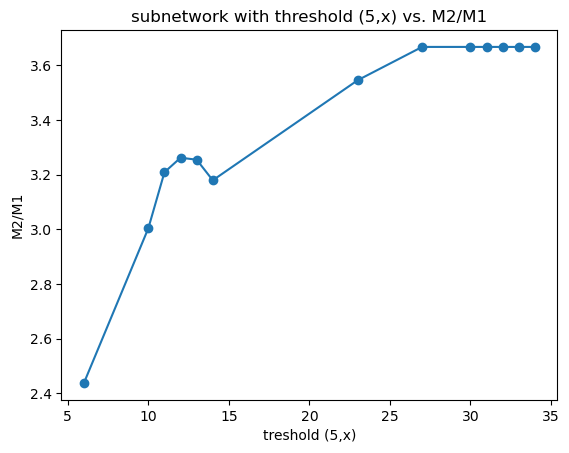

In [22]:
filtered_data5 = [(tup[1], tup[2]) for tup in toPlot if tup[0] == 5]
filtered_data5 = sorted(filtered_data5, key=lambda x: x[0])
x_values, y_values = zip(*filtered_data5)

# Plot erstellen
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('treshold (5,x)')
plt.ylabel('M2/M1')
plt.title('subnetwork with threshold (5,x) vs. M2/M1')
plt.show()

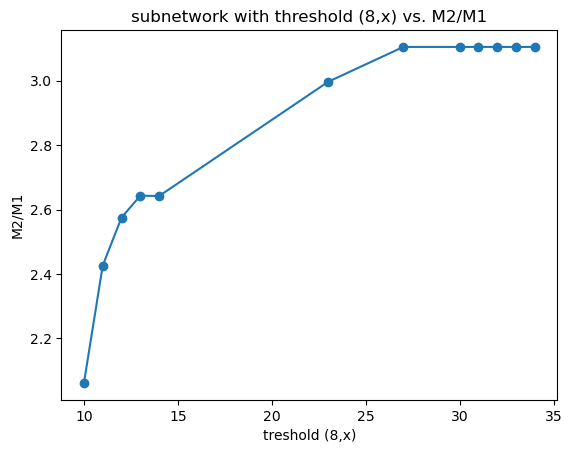

In [23]:
filtered_data8 = [(tup[1], tup[2]) for tup in toPlot if tup[0] == 8]
filtered_data8 = sorted(filtered_data8, key=lambda x: x[0])
x_values, y_values = zip(*filtered_data8)

# Plot erstellen
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('treshold (8,x)')
plt.ylabel('M2/M1')
plt.title('subnetwork with threshold (8,x) vs. M2/M1')
plt.show()

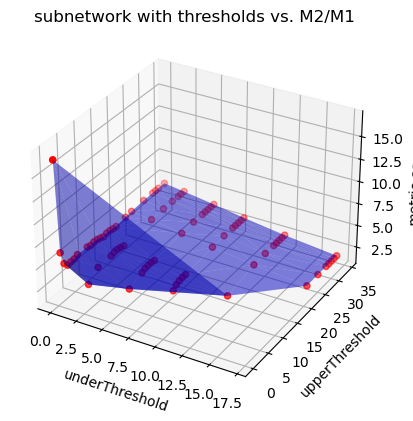

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
data=toPlot
x1_values = [entry[0] for entry in data]
x2_values = [entry[1] for entry in data]
x3_values = [entry[2] for entry in data]

# Erstelle den 3D-Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Punkte plotten
ax.scatter(x1_values, x2_values, x3_values, c='r', marker='o')

# Verbinde die Punkte durch Flächen
ax.plot_trisurf(x1_values, x2_values, x3_values, color='b', alpha=0.5)

# Beschriftungen der Achsen
ax.set_xlabel('underThreshold')
ax.set_ylabel('upperThreshold')
ax.set_zlabel('metric-score')
plt.title('subnetwork with thresholds vs. M2/M1')

plt.show()

## Evaluation against other climate models

In [25]:
metric2_div_metric1=dict(sorted(metric2_div_metric1.items(), key=lambda x: x[0][1]))

In [26]:
def scatter_plot_2(data,model_nr,title,name,save_name,vmin,vmax,nr_intervals,label):
    size_s=40
    nr_models=len(data[:,0,0,0])
    average=0
    n_ensembles=nr_intervals
    all_values = []  # Hier werden alle Werte gesammelt

    for i in range(0,nr_models):
#         print i                                                                                                                                                                                                                                                           
#         if name[i]==name[model_nr]:                                                                                                                                                                                                                                       
#             print name[i]                                                                                                                                                                                                                                                 
        if name[i] in ['era', 'NCEP']: #2*datashape 3
            plt.scatter(np.ones((nr_intervals**2))*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)     #da auch r zu k
            else:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        else:
#             print name[i],data[model_nr,i,:,:].flatten()[0:n_ensembles]                                                                                                                                                                                                   
            plt.scatter(np.ones(4*4)*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)              #da x color ändern
            else:
                average+=np.nanmean(data[model_nr,i,:,:],axis=(0,1))
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        all_values.extend(data[model_nr, i, :, :].flatten())

    min_value = np.nanmin(all_values)
    max_value = np.nanmax(all_values)

    
    
    #### REVISE
    average/=(nr_models-1) #    average/=double(nr_models-1)
    print('average', average)
    plt.plot(np.linspace(-0.5,nr_models+1,100)-0.25,np.ones((100))*average,color='gray',linestyle='--',linewidth=2)
    plt.xticks(np.arange(0,nr_models),name[:],rotation=90,size=12)
    plt.ylabel(label,size=16,fontweight='bold')
    plt.xlim(-0.5,nr_models-0.5)
    #plt.ylim(vmin,vmax)
    plt.ylim(max(0, min_value-0.1), min(1, max_value+0.03))
    #plt.title(title,fontweight='bold',size=12)
    plt.title('Reference: ' + model_names[model_nr],fontweight='bold',size=12)
    title=model_names[model_nr]
    title='Reference: ' + model_names[model_nr]
   # plt.savefig('./BilderBA/'+title+'SUBNETWORK(0,5).pdf', dpi=600, format='pdf', bbox_inches='tight')
    plt.show()
    plt.close()

average 0.18014466374252633


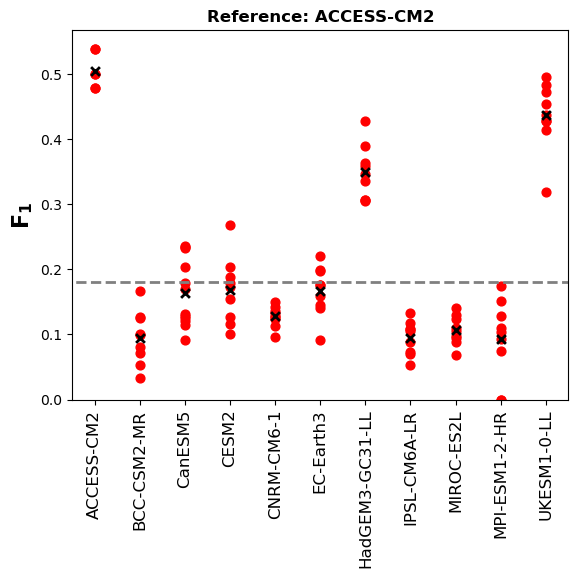

average 0.11195412436059679


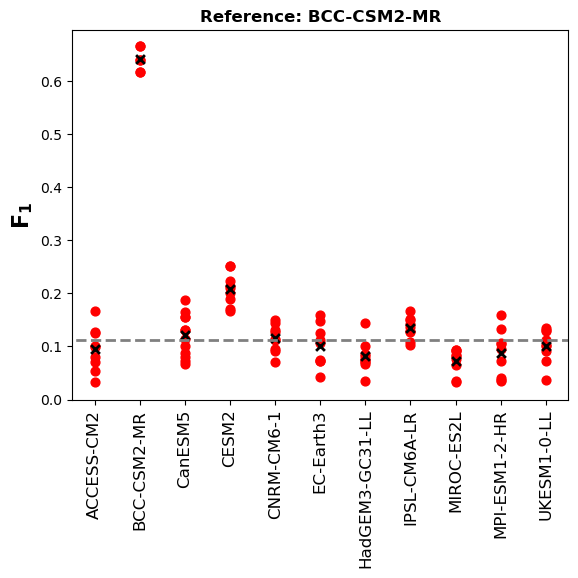

average 0.13230957181784858


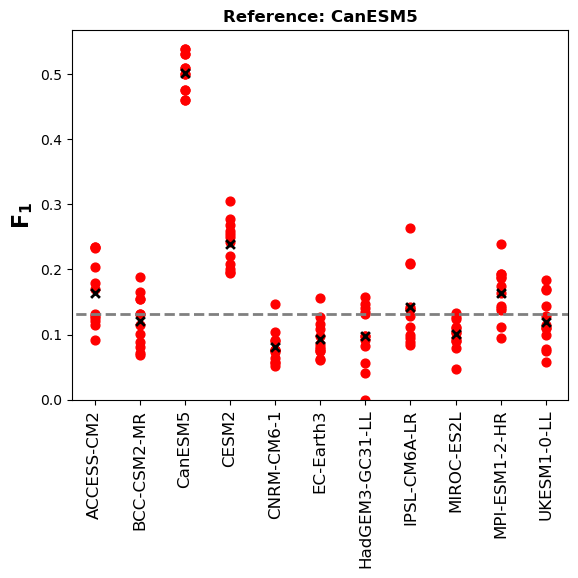

average 0.13782542380624754


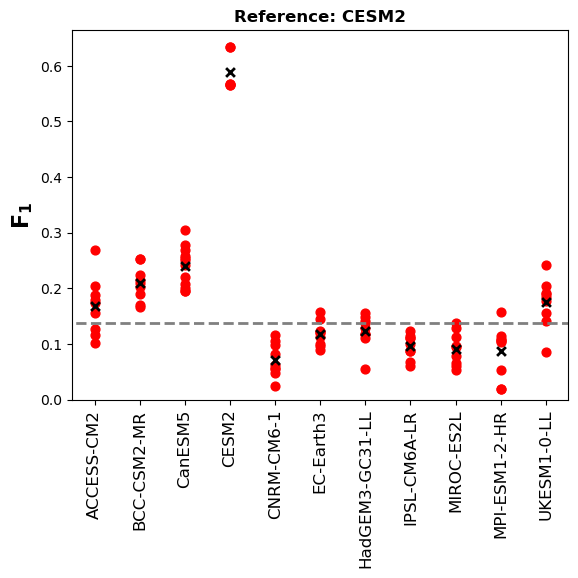

average 0.143245132584063


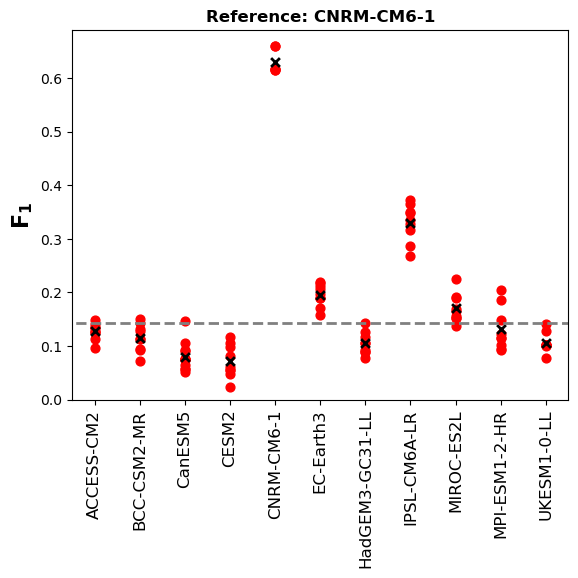

average 0.14823656143383207


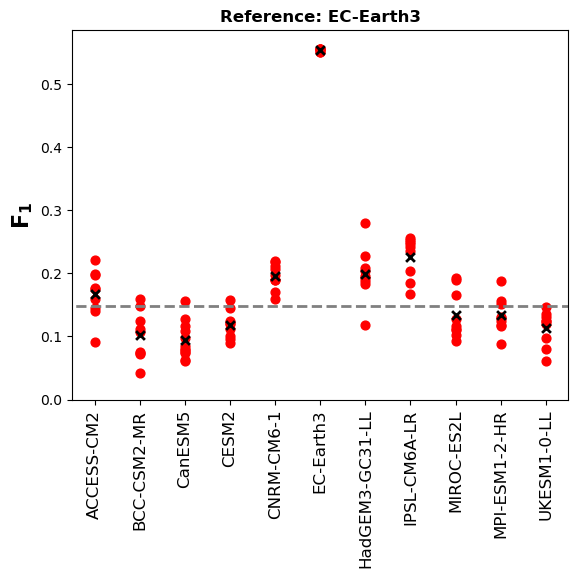

average 0.16437768509671238


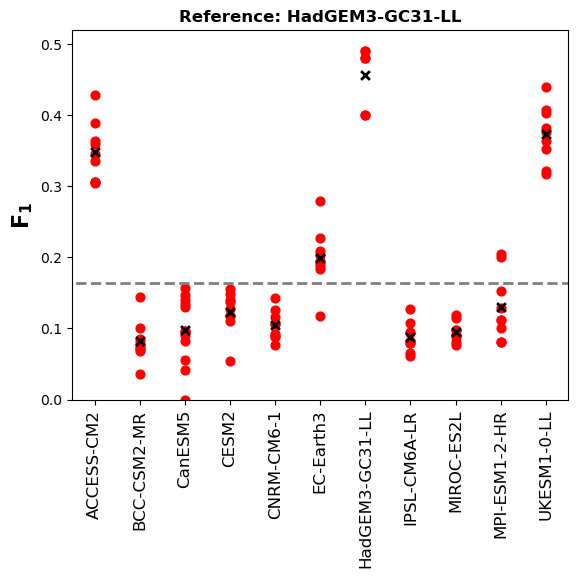

average 0.15425841696939607


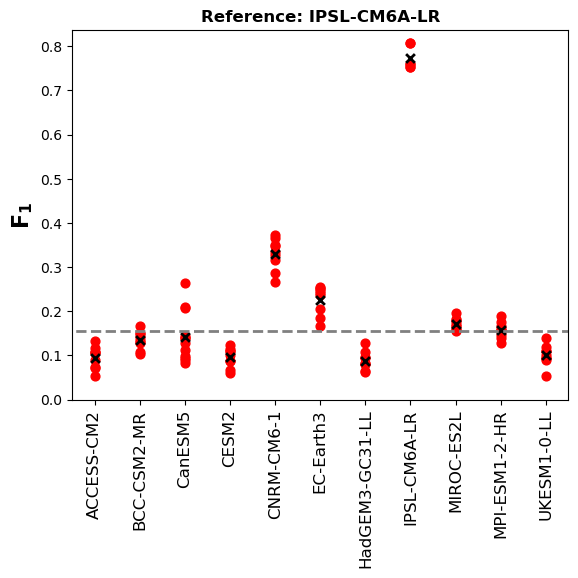

average 0.11344390919424208


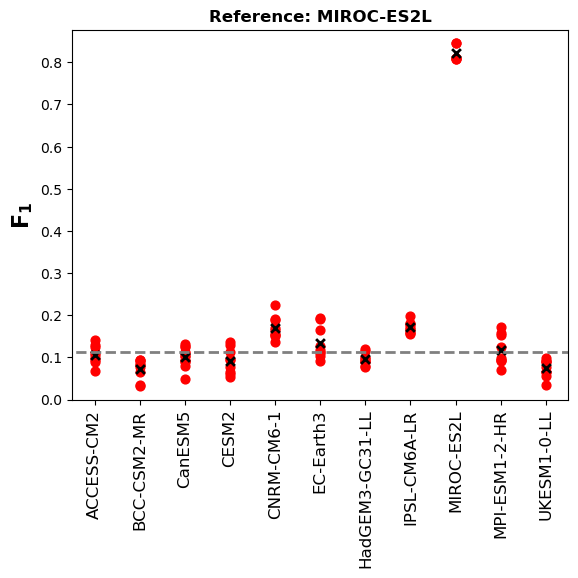

average 0.12238514711181411


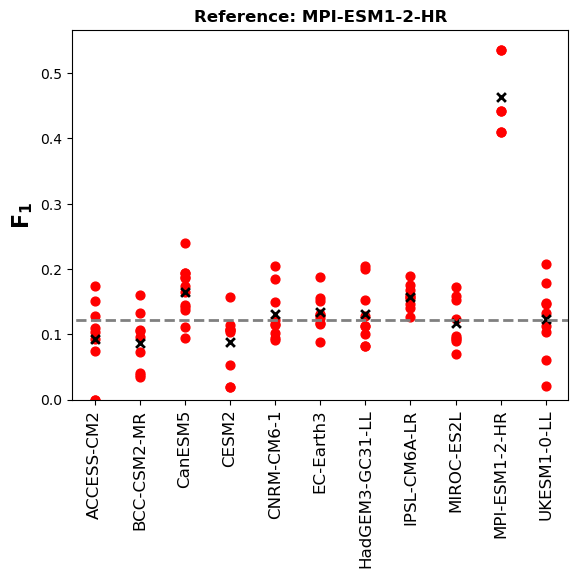

average 0.172495533109964


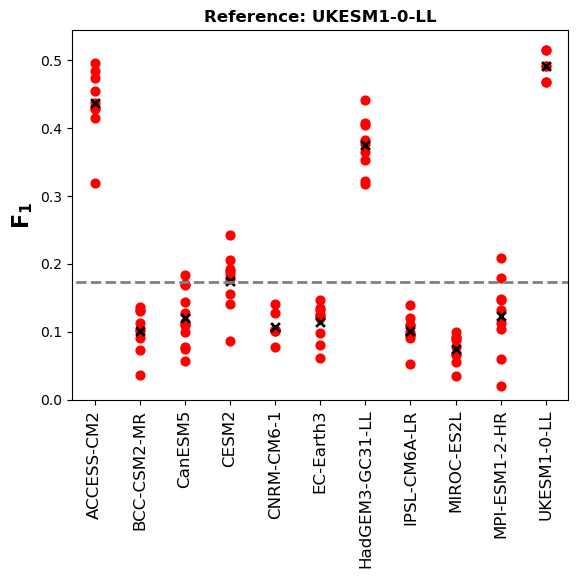

In [27]:
for key in sorted_dict_komps:
    #print(key)
    if(key[3] != (0, 5)): #choose threshold
        continue
    for refModelIndex, model in enumerate(model_names):    
        scatter_plot_2(f1Scores_[key][0.0001], refModelIndex, "comps: " + str(key[0]) + "|pc_alpha: " + str (key[1]) + "|alpha_value: " + str(key[2]), model_names, 'scatterplot2', 0.5, 1, 3, r'F$_{\mathbf{1}}$')

In [28]:
temp=[]
plotLinksMap=[]

In [29]:
for setting in f1ScoresLinks:
    plotLinks=[]
    threshold=setting[3]
    if threshold[0]>0:
        continue
    for key in f1ScoresLinks[setting][1]:
        plotLinks.append(key)
        if threshold==(0,3):         #choose threshold which should be visualized
            plotLinksMap.append(key)
    temp.append((threshold, len(plotLinks)))

In [30]:
toPlot2 = sorted(temp, key=lambda x: x[0][1])
toPlot2.pop()

((0, 34), 3858)

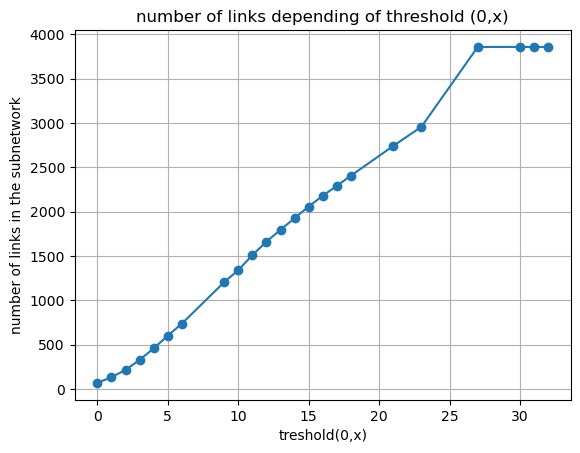

In [31]:
x_values = [entry[0][1] for entry in toPlot2]
y_values = [entry[1] for entry in toPlot2]

# Plot
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('treshold(0,x)')
plt.ylabel('number of links in the subnetwork')
plt.grid(True)
title='subnetworkNumberOfLinksThreshold(0,x)'
plt.title('number of links depending of threshold (0,x)')
#plt.savefig('./BilderBA/'+title+'.pdf',dpi=600, format='pdf', bbox_inches='tight')
plt.show()

## Visualization links

### setup

In [32]:



CIMP6Data = "/mnt/c/Users/Megaport/desktop/BA_Backup/BA/Data/c-transfer"
#path depending on timebin
pca_res_path="/mnt/c/Users/Megaport/desktop/BA_Backup/BA/Data/CMIP6/c-transfer"
pcmci_res_path="/mnt/c/Users/Megaport/desktop/BA_Backup/BA/Data/CMIP6/PCMCI/output/gridSearch/alpha=3e-20_nVAR=100"
use_CMIP6_data=True


alpha_levelTest=0.0001




make_dic=True 
n_kept_comp = 100 #number of kept PCA comp time series       
selected_comps_indices=[i for i in range(0,n_kept_comp)]
var_names=["X_"+str(i) for i in range(0,n_kept_comp)]

plotDict={}
f1Dict={}
graph_mat_dict={}
p_mat_dict={}
val_mat_dict={}


resTestPath=pcmci_res_path+"/results_*.bin"
resTest1=None
file_nameTest=""
for res_file in glob.glob(pcmci_res_path+"/results_*.bin"):      
    res = pickle.load(open(res_file,"rb"))
    resTest = res
    resTest1=resTest
    #print(resTest1)
    file_nameTest = resTest1['file_name']
    name=file_nameTest
    file_nameTest = pca_res_path+"/"+ file_nameTest
    info_model= file_nameTest.split("_")
    dataset_name = info_model[3]               #on error change to 2 or 3
    ensemble=""
    if dataset_name != "ncar":
        dataset_name= info_model[3]
        if use_CMIP6_data:
            ensemble= info_model[6]  #on error change to 5 or 6
        else : ensemble= info_model[7]
    if dataset_name == "GISS-E2-R":
        ensemble= info_model[5]
    if dataset_name == "ERA5":
        ensemble= ""
    season= info_model[-1][7:-4]


    datadictTest = cPickle.load(open(file_nameTest, 'rb'))
    dTest = datadictTest['results']
    time_maskTest = dTest['time_mask']
    dateseriesTest = dTest['time'][:]
    fulldataTest = dTest['ts_unmasked']
    N = fulldataTest.shape[1]
    fulldata_mask = np.repeat(time_maskTest.reshape(len(dTest['time']), 1), N, axis=1)

    fulldataTest = fulldataTest[:, selected_comps_indices]
    fulldata_mask = fulldata_mask[:, selected_comps_indices]
    dataframeTest = pp.DataFrame(fulldataTest, mask=fulldata_mask)
    T, N = dataframeTest.values[0].shape
    CI_params = {       'significance':'analytic', 
                                'mask_type':['y'],
                                'recycle_residuals':False,
                                }
    cond_ind_test = ParCorr(**CI_params)
    pcmci=PCMCI(cond_ind_test=cond_ind_test,dataframe=dataframeTest, verbosity=0)



    graphTest = pcmci.get_graph_from_pmatrix(p_matrix=resTest1['results']['p_matrix'],
                                     alpha_level=alpha_levelTest,
                                     tau_min=1,
                                     tau_max=10,
                                     link_assumptions=None,)

    valMatrixTest = resTest1['results']['val_matrix']
    
    plotDict[file_nameTest]=(graphTest, valMatrixTest, datadictTest, name)
    #f1Dict[file_nameTest]=(graphTest, resTest1['results']['p_matrix'], valMatrixTest, dataset_name, ensemble, season)
    graph_mat_dict.setdefault(season,{})
    graph_mat_dict[season].setdefault(dataset_name,{})
    graph_mat_dict[season][dataset_name]
    graph_mat_dict[season][dataset_name][ensemble] = graphTest
    val_mat_dict.setdefault(season,{})
    val_mat_dict[season].setdefault(dataset_name,{})
    val_mat_dict[season][dataset_name].setdefault(ensemble,None)
    val_mat_dict[season][dataset_name][ensemble]=valMatrixTest
    p_mat_dict.setdefault(season,{})
    p_mat_dict[season].setdefault(dataset_name,{})
    p_mat_dict[season][dataset_name].setdefault(ensemble,)
    p_mat_dict[season][dataset_name][ensemble]=resTest1['results']['p_matrix']



In [33]:
coordsDict={}


for key in plotDict:

    lonsTest=datadictTest['results']['lons']
    latsTest=datadictTest['results']['lats']
    #print(weightsTest.shape)
    #np.argmax(weightsTest)
    #print(lonsTest.shape)
    #print(latsTest.shape)
    #print(lonsTest)
    #print(latsTest)
    weightsTest=datadictTest['results']['weights']
    weightsTest=np.array(weightsTest.reshape(len(latsTest),len(lonsTest), 100))
    #coordsMax=np.argmax(weightsTest, keepdims=True)


    coords = []
    for k in range(0, n_kept_comp):
        i,j = np.unravel_index(np.argmax(np.abs(weightsTest[:,:,k])), weightsTest[:,:,k].shape)
        coords.append((latsTest[i], lonsTest[j]))
    coordsDict[key]=(lonsTest, latsTest, weightsTest, coords)
    #print(coords)
    #print(coordsMax)
    #print(weightsTest.shape)
    #print(weightsTest[:,:,0]) #reihe = lat column = lon


## plot subnetwork

varimax_CMIP6_ACCESS-CM2_day_historical_r1i1p1f1_psl_1979-2014_detrend.nc_100-comps_timebin-3_months-[6, 7, 8].bin


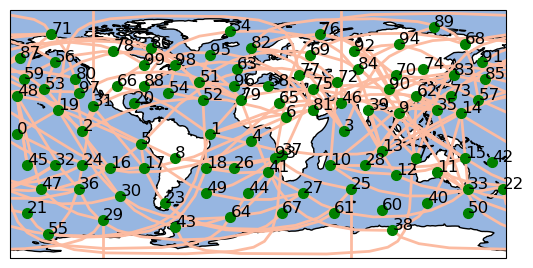

In [34]:
#cartopy Zeugs
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.feature as cfeature
import matplotlib as mpl


cmapReds = mpl.cm.Reds
cmapBlues = mpl.cm.Blues
normReds = mpl.colors.Normalize(vmin=0, vmax=1)
normBlues = mpl.colors.Normalize(vmin=0, vmax=1)

count = 0

for key in plotDict:
    if count>0:
        break
    file_name = '/'.join(str(key).split('/')[-1:])  #just get file name in some way (other ways possible)


    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_global()

  #  print("(-->, i, j, tau) = Kante von i nach j in Zeitschritt tau")
    graphTest=plotDict[key][0]
    valMatrixTest=plotDict[key][1]
    coords=coordsDict[key][3]
    
    tempDict = {}
   
    for i in range(0, n_kept_comp):
        for j in range(0, n_kept_comp):
            for k in range(0,11): #range von 0 bis tau_max+1
                if (i,j,k) in plotLinksMap:
                    if i<j:
                        color = cmapReds(normReds(0.25))
                        tempDict[(i,j)]=0.5                  
                        plt.plot([coords[i][1], coords[j][1]], [coords[i][0], coords[j][0]],
                             color=color, linewidth=2, marker=None, transform=ccrs.Geodetic())
          #  print("------------------------------------------------")


    #Idee für nächstes mal: In jedem Schleifendurchlauf den max. Wert der in Frage kommt merken und erst ganz am Ende schauen
    #was der max Wert ist und diesen für die Pfeilfarbe benutzen

    #print(tempDict)


    for i, element in enumerate(coords):
        ax.plot(element[1],element[0], 'go', markersize=7, transform=ccrs.Geodetic())
        ax.text(element[1], element[0], i, transform=ccrs.Geodetic(), fontsize=12, color='black',)
    #plt.savefig('./BilderBA/' + 'best subnetwork_lag1' + '_karte.pdf', format='pdf', dpi=300, bbox_inches='tight')
    print(file_name)

    plt.show()
    count += 1

### plot subnetwork arrowstyle

varimax_CMIP6_ACCESS-CM2_day_historical_r1i1p1f1_psl_1979-2014_detrend.nc_100-comps_timebin-3_months-[6, 7, 8].bin


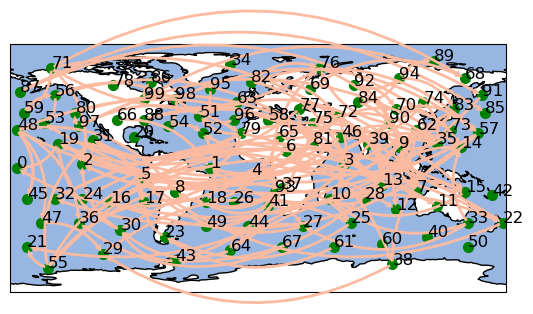

In [35]:
#cartopy Zeugs
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cartopy.feature as cfeature
import matplotlib as mpl


cmapReds = mpl.cm.Reds
cmapBlues = mpl.cm.Blues
normReds = mpl.colors.Normalize(vmin=0, vmax=1)
normBlues = mpl.colors.Normalize(vmin=0, vmax=1)

count=0

for key in plotDict:
    if count>0:
        break
    file_name = '/'.join(str(key).split('/')[-1:])


    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_global()

  #  print("(-->, i, j, tau) = Kante von i nach j in Zeitschritt tau")
    graphTest=plotDict[key][0]
    valMatrixTest=plotDict[key][1]
    coords=coordsDict[key][3]
    
    tempDict = {}
   
    for i in range(0, n_kept_comp):
        for j in range(0, n_kept_comp):
            for k in range(0, 11):  # range von 0 bis tau_max+1
                if (i, j, k) in plotLinksMap:
                    if i < j:
                        color = cmapReds(normReds(0.25))
                        tempDict[(i, j)] = 0.5
                        # Zeichnen des Pfeils von i nach j
                        ax.annotate('', xy=(coords[i][1], coords[i][0]), xytext=(coords[j][1], coords[j][0]),
                            xycoords='data',
                            size=10,
                            arrowprops=dict(facecolor=color, ec = 'none',
                                arrowstyle="simple",
                                connectionstyle="arc3,rad=-0.3"))

          #  print("------------------------------------------------")


    #Idee für nächstes mal: In jedem Schleifendurchlauf den max. Wert der in Frage kommt merken und erst ganz am Ende schauen
    #was der max Wert ist und diesen für die Pfeilfarbe benutzen

    #print(tempDict)


    for i, element in enumerate(coords):
        ax.plot(element[1],element[0], 'go', markersize=7, transform=ccrs.Geodetic())
        ax.text(element[1], element[0], i, transform=ccrs.Geodetic(), fontsize=12, color='black',)
   # plt.savefig('./BilderBA/' + 'best subnetwork_lag1(0,3)' + '_karte.pdf', format='pdf', dpi=300, bbox_inches='tight')
    print(file_name)

    plt.show()
    count+=1

## comparison on observation data


In [36]:
subnet=f1ScoresLinks[(3e-20, 100, 'range(0, 100)', (0, 30))][1] #apply optimal hyperparameter setting used for inferring the subnetwork

In [37]:
def f1score_modelAll(ref_dataset, val_mat_dict, p_mat_dict, link_mat_dic, alpha_levelTest, f14d):
    df_f1score= {}
    ref_ds=ref_dataset
    val_mat_dic= val_mat_dict
    p_mat_dic=p_mat_dict
    score_list =[]
    score_list2=[]
    for season in link_mat_dic:
        if season !="global":#drop global
            for dataset in link_mat_dic[season]: 
                #print(link_mat_dic[season].keys())
                #print(dataset)
                for i, ensemble in enumerate(link_mat_dic[season][dataset]):
                    if (dataset!=ref_ds or dataset==ref_ds) and dataset!='ncar':
                        datasetIndex=model_names.index(dataset)
                        refdatasetIndex=model_names.index(ref_dataset)
                        for j, ref_ds_ensemble in enumerate(link_mat_dic[season][ref_ds]):                      
                            #von hier
                            ref_p_matrix= p_mat_dic[season][ref_ds][ref_ds_ensemble]
                            ref_val_matrix= val_mat_dic[season][ref_ds][ref_ds_ensemble]
                            #bis hier über alle ref_ds gehen in for loop
                            p_matrix= p_mat_dic[season][dataset][ensemble]
                            val_matrix= val_mat_dic[season][dataset][ensemble]
                            precision, recall, TP, FP, FN, score, auto, count = get_metric_f1(ref_p_matrix, p_matrix, ref_val_matrix, val_matrix, alpha_levelTest, subnet,
                            tau_min=1, tau_diff=2, same_sign=True)
                            score_list.append([season,dataset,ensemble,score])
                            score_list2.append([season,dataset,ensemble,score,ref_ds_ensemble])
                            if not ((datasetIndex==refdatasetIndex) and (i==j)):                               
                                f14d[refdatasetIndex][datasetIndex][j][i]=score #kann sein dass hier die indizes vertauscht sind

    season,dataset,ensemble,score= [list(a) for a in zip(*score_list)]
    df_f1score_ = pd.DataFrame({"season":season,"model":dataset,"ensemble":ensemble,"F1-score":score})
    #get average F1-score over seasons
    df_f1score_seasonaveraged = df_f1score_.groupby(["model"])["F1-score"].mean().rename("F1-score",inplace=True).to_frame()
    return score_list2

In [38]:
def get_metric_f1(ref_p_matrix, p_matrix, ref_val_matrix, val_matrix, alpha, subnet, 
            tau_min=0, tau_diff=1, same_sign=True):
    tau_diff=0
    tau_min=1

    N, N, taumaxp1 = val_matrix.shape
    TP = 0
    FP = 0
    FN = 0
    auto = 0
    count = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                for tau in range(tau_min, taumaxp1):
                    if (i,j,tau) in subnet:
                        if (len(subnet[(i,j,tau)]) > 0):
                            if tau==0:
                                if i<j:
                                    if ref_p_matrix[i,j,tau] > alpha and p_matrix[i,j,tau] < alpha:
                                        FP += 1
                                    elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha): #dann gibt es vlt. einen nicht contemp. link i->j oder contemp. link o-o 
                                        count +=1
                                        if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[i,j,tau]):
                                            TP += 1
                                        elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[i,j,tau]):
                                            FN += 1
                                        elif same_sign==False:
                                            TP += 1
                                    elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[j,i,max(0,tau-tau_diff):tau+tau_diff+1] < alpha): #dann gibt es vlt. einen nicht contemp. link j->i oder contemp. link o-o
                                        count +=1
                                        if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[j,i,tau]):
                                            TP += 1
                                        elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[j,i,tau]):
                                            FN += 1
                                        elif same_sign==False:
                                            TP += 1
                                    elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                                        FN += 1
                                    elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[j,i,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                                        FN += 1
                            else:
                                if ref_p_matrix[i,j,tau] > alpha and p_matrix[i,j,tau] < alpha:
                                    FP += 1
                                elif ref_p_matrix[i,j,tau] < alpha and np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha):
                                    count +=1
                                    if same_sign==True and np.sign(ref_val_matrix[i,j,tau]) == np.sign(val_matrix[i,j,tau]):
                                        TP += 1
                                    elif same_sign==True and np.sign(ref_val_matrix[i,j,tau]) != np.sign(val_matrix[i,j,tau]):
                                        FN += 1
                                    elif same_sign==False:
                                        TP += 1
                                elif ref_p_matrix[i,j,tau] < alpha and not(np.any(p_matrix[i,j,max(0,tau-tau_diff):tau+tau_diff+1] < alpha)):
                                    FN += 1
            else:
                auto +=1
    precision =  float(TP+1e-10) / float(TP + FP +1e-10)
    recall = float(TP+1e-10) / float(TP + FN +1e-10)
    f1 = 2.0*precision*recall/float(precision + recall)
    #print(f1, precision, recall, TP, FP, FN)
    return precision, recall, TP, FP, FN, f1, auto, count

In [39]:
pcmci_res_path="./output/gridSearch/alpha=3e-20_nVAR=100"
alpha_levelTest=0.0001
make_dic=True
use_CMIP6_data = True

In [40]:
model_names=['ACCESS-CM2', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC-ES2L',
             'MPI-ESM1-2-HR', 'UKESM1-0-LL', 'ncar']

In [41]:
graph_mat_dict={}
val_mat_dict={}
p_mat_dict={}
allResults={}

for res_file in glob.glob(pcmci_res_path+"/results_*.bin"):       
    res = pickle.load(open(res_file,"rb"))
    resTest = res
    resTest1=resTest
    pc_alpha=resTest1['PC_params']['pc_alpha']              
    tau_max=resTest1['PC_params']['tau_max']
    file_nameTest = resTest1['file_name']

    n_kept_comp=len(resTest1['PC_params']['selected_variables'])
    selected_comps_indices=[i for i in range(0,n_kept_comp)]
    var_names=["X_"+str(i) for i in range(0,n_kept_comp)]

    name=file_nameTest
  #  print(f"calculating for {name} with alphaLevel = {alpha_levelTest}")
    file_nameTest = pca_res_path+"/"+ file_nameTest
    info_model= file_nameTest.split("_")
    #print("info model liste ist ", info_model)
    dataset_name = info_model[2]               # on error, change to entry 2 or 3
    ensemble=""
    if dataset_name != "ncar":
        dataset_name= info_model[3] #on error, change to entry 2,3,4
        if use_CMIP6_data:
            ensemble= info_model[6]  #on error, change to entry 5,6,7                                   
        else : ensemble= info_model[7]
    if dataset_name == "GISS-E2-R":
        ensemble= info_model[5]
    if dataset_name == "ERA5":
        ensemble= ""
    season= info_model[-1][7:-4]
  #  print(dataset_name)
   # print(ensemble)


    datadictTest = cPickle.load(open(file_nameTest, 'rb'))
    dTest = datadictTest['results']
    time_maskTest = dTest['time_mask']
    dateseriesTest = dTest['time'][:]
    fulldataTest = dTest['ts_unmasked']
    N = fulldataTest.shape[1]
    fulldata_mask = np.repeat(time_maskTest.reshape(len(dTest['time']), 1), N, axis=1)

    fulldataTest = fulldataTest[:, selected_comps_indices]
    fulldata_mask = fulldata_mask[:, selected_comps_indices]
    dataframeTest = pp.DataFrame(fulldataTest, mask=fulldata_mask)
    T, N = dataframeTest.values[0].shape
    CI_params = {       'significance':'analytic', 
                                'mask_type':['y'],
                                'recycle_residuals':False,
                                }
    cond_ind_test = ParCorr(**CI_params)
    pcmci=PCMCI(cond_ind_test=cond_ind_test,dataframe=dataframeTest, verbosity=0)



    graphTest = pcmci.get_graph_from_pmatrix(p_matrix=resTest1['results']['p_matrix'],
                                    alpha_level=alpha_levelTest,
                                    tau_min=1,
                                    tau_max=10,
                                    link_assumptions=None,)

    valMatrixTest = resTest1['results']['val_matrix']

    graph_mat_dict.setdefault(season,{})
    graph_mat_dict[season].setdefault(dataset_name,{})
    graph_mat_dict[season][dataset_name]
    graph_mat_dict[season][dataset_name][ensemble] = graphTest
    val_mat_dict.setdefault(season,{})
    val_mat_dict[season].setdefault(dataset_name,{})
    val_mat_dict[season][dataset_name].setdefault(ensemble,None)
    val_mat_dict[season][dataset_name][ensemble]=valMatrixTest
    p_mat_dict.setdefault(season,{})
    p_mat_dict[season].setdefault(dataset_name,{})
    p_mat_dict[season][dataset_name].setdefault(ensemble,)
    p_mat_dict[season][dataset_name][ensemble]=resTest1['results']['p_matrix']
    allResults.setdefault(alpha_levelTest, {})
    allResults[alpha_levelTest].setdefault('graph_mat_dict', {})
    allResults[alpha_levelTest].setdefault('val_mat_dict', {})
    allResults[alpha_levelTest].setdefault('p_mat_dict', {})       
    allResults[alpha_levelTest]['graph_mat_dict']=graph_mat_dict
    allResults[alpha_levelTest]['val_mat_dict']=val_mat_dict
    allResults[alpha_levelTest]['p_mat_dict']=p_mat_dict

In [42]:
resDict={}
for key in allResults.keys():
    modelRes=allResults[key]
    graph_mat_dict=modelRes['graph_mat_dict']
    val_mat_dict=modelRes['val_mat_dict']
    p_mat_dict=modelRes['p_mat_dict']
    f14d=np.empty((len(model_names), len(model_names), 4, 4))
    shape=(len(model_names), len(model_names), 4, 4)
    f14d = np.full(shape, np.nan)
    
    x=f1score_modelAll('ncar', val_mat_dict, p_mat_dict, graph_mat_dict, key, f14d)

    resDict[key]=f14d

In [43]:
def scatter_plot_2_ncar(data,model_nr,title,name,save_name,vmin,vmax,nr_intervals,label):
    size_s=40
    nr_models=len(data[:,0,0,0])
    average=0
    n_ensembles=nr_intervals
    all_values = []  # Hier werden alle Werte gesammelt

    for i in range(0,nr_models):
        if i==11:
            continue
#         print i                                                                                                                                                                                                                                                           
#         if name[i]==name[model_nr]:                                                                                                                                                                                                                                       
#             print name[i]                                                                                                                                                                                                                                                 
        if name[i] in ['era', 'NCEP']: #2*datashape 3
            plt.scatter(np.ones((nr_intervals**2))*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)     #da auch r zu k
            else:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        else:
#             print name[i],data[model_nr,i,:,:].flatten()[0:n_ensembles]                                                                                                                                                                                                   
            plt.scatter(np.ones(4*4)*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)              #da x color ändern
            else:
                average+=np.nanmean(data[model_nr,i,:,:],axis=(0,1))
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        all_values.extend(data[model_nr, i, :, :].flatten())

    min_value = np.nanmin(all_values)
    max_value = np.nanmax(all_values)

    
    
    #### REVISE
    average/=(nr_models-1) #    average/=double(nr_models-1)
    print('average', average)
    plt.plot(np.linspace(-0.5,nr_models+1,100)-0.25,np.ones((100))*average,color='gray',linestyle='--',linewidth=2)
    plt.xticks(np.arange(0, nr_models - 1), name[:-1], rotation=90, size=12)
    plt.ylabel(label,size=16,fontweight='bold')
    plt.xlim(-0.5, nr_models - 1 - 0.5)  # Anpassen des X-Achsenbereichs
    #plt.ylim(vmin,vmax)
    plt.ylim(max(0, min_value-0.1), min(1, max_value+0.1))
    #plt.title(title,fontweight='bold',size=12)
    plt.title('Reference: ' + model_names[model_nr],fontweight='bold',size=12)
    
    #plt.savefig('./BilderBA/ncarvspcalpha=1e-20notsorted_subnetworkf1normal(0,30).pdf', bbox_inches='tight')
    plt.show()
    plt.close()

average 0.6132723973391208


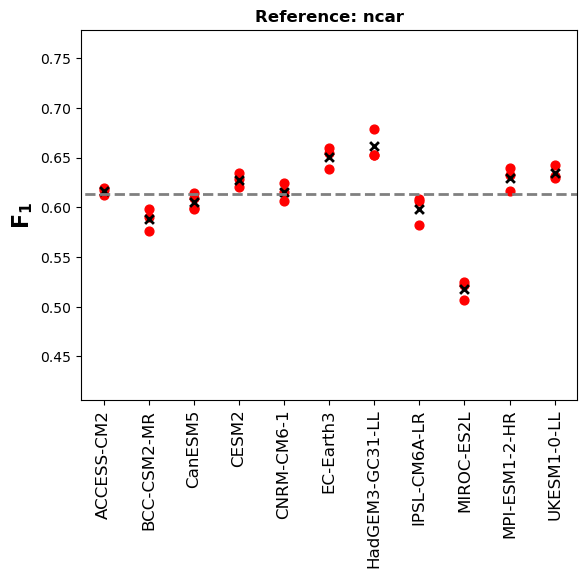

In [44]:
scatter_plot_2_ncar(resDict[0.0001], 11, "comps: " + str(100) + "|pc_alpha: " + str (3e-25) + "|alpha_value: " + str(0.001), model_names, 'scatterplot2', 0.5, 1, 3, r'F$_{\mathbf{1}}$')